In [35]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
import math
import warnings
from tqdm import tqdm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from pandas.api.types import is_float_dtype
warnings.filterwarnings('ignore')

In [36]:

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

In [65]:
class ParkingComplaintPredictor:
    def __init__(self, random_state=42):
        self.random_state = random_state
        self.scaler = StandardScaler()
        self.label_encoders = {}
        self.model = None
        self.feature_names = []
        self.log_target = False  # 로그 변환 여부 플래그

    def load_data(self, parking_file, complaint_file):
        """
        주차장 데이터와 민원 데이터 로드
        """
        self.parking_df = pd.read_csv(parking_file)
        self.complaint_df = pd.read_csv(complaint_file)
        
        print(f"주차장 데이터 로드: {len(self.parking_df)}개")
        print(f"민원 데이터 로드: {len(self.complaint_df)}개")
        
        # 컬럼명 출력 (확인용)
        print("\n주차장 데이터 컬럼:")
        print(self.parking_df.columns.tolist())
        print("\n민원 데이터 컬럼:")
        print(self.complaint_df.columns.tolist())
        
    def haversine_distance(self, lat1, lon1, lat2, lon2):
        """
        하버사인 공식을 사용하여 두 지점 간의 거리를 미터 단위로 계산
        """
        # 지구 반지름 (미터)
        R = 6371000
        
        # 도를 라디안으로 변환
        lat1_rad = math.radians(lat1)
        lon1_rad = math.radians(lon1)
        lat2_rad = math.radians(lat2)
        lon2_rad = math.radians(lon2)
        
        # 위도와 경도 차이
        dlat = lat2_rad - lat1_rad
        dlon = lon2_rad - lon1_rad
        
        # 하버사인 공식
        a = math.sin(dlat/2)**2 + math.cos(lat1_rad) * math.cos(lat2_rad) * math.sin(dlon/2)**2
        c = 2 * math.asin(math.sqrt(a))
        
        # 거리 계산 (미터)
        distance = R * c
        
        return distance
    
    def preprocess_features(self):
        """
        주차장 특성 전처리 - 새로운 데이터셋에 맞게 수정
        """
        # 수치형 특성 (새로운 컬럼들 포함)
        numeric_features = [
            '총주차면', '1시간 요금',
            '평일운영시간', '토요일운영시간', '공휴일운영시간',
            'cctv_r300'
        ]
        
        # 범주형 특성
        categorical_features = ['주차장종류', '운영구분']
        
        # 유료/무료 정보를 숫자로 변환 (유료=1, 무료=0)
        fee_columns = ['평일유료', '토요일유료', '공휴일유료']
        for col in fee_columns:
            if col in self.parking_df.columns:
                # 다양한 유료/무료 표현 방식 처리
                self.parking_df[col + '_encoded'] = self.parking_df[col].apply(
                    lambda x: 1 if str(x).lower() in ['유료', 'y', 'yes', '1', 'true'] else 0
                )
        
        # 파생 변수 생성
        # 1. 수익잠재력 (총주차면 × 1시간요금)
        if '총주차면' in self.parking_df.columns and '1시간 요금' in self.parking_df.columns:
            self.parking_df['수익잠재력'] = self.parking_df['총주차면'] * self.parking_df['1시간 요금']
        
        # 2. 평균 운영시간 계산
        time_cols = ['평일운영시간', '토요일운영시간', '공휴일운영시간']
        available_time_cols = [col for col in time_cols if col in self.parking_df.columns]
        if available_time_cols:
            self.parking_df['평균운영시간'] = self.parking_df[available_time_cols].mean(axis=1)
        
        # 3. 총 유료일수 (평일, 토요일, 공휴일 중 유료인 날의 수)
        fee_encoded_cols = [col + '_encoded' for col in fee_columns if col in self.parking_df.columns]
        if fee_encoded_cols:
            self.parking_df['총유료일수'] = self.parking_df[fee_encoded_cols].sum(axis=1)
        
        # # 4. 요금 효율성 (기본주차시간 대비 기본주차요금)
        # if '기본주차요금' in self.parking_df.columns and '기본주차시간' in self.parking_df.columns:
        #     self.parking_df['요금효율성'] = self.parking_df['기본주차요금'] / (self.parking_df['기본주차시간'] + 1e-6)  # 0으로 나누기 방지
        
        # # 5. 추가요금 부담도 (추가단위요금 / 추가단위시간)
        # if '추가단위요금' in self.parking_df.columns and '추가단위시간' in self.parking_df.columns:
        #     self.parking_df['추가요금부담도'] = self.parking_df['추가단위요금'] / (self.parking_df['추가단위시간'] + 1e-6)
        
        # 6. 인프라 밀도 (CCTV + 버스정류장)
        if 'cctv_r300' in self.parking_df.columns and 'bus_r300' in self.parking_df.columns:
            self.parking_df['인프라밀도'] = self.parking_df['cctv_r300'] + self.parking_df['bus_r300']
        
        # 7. 민원 밀도 대비 주차면 (complaints_r300 대비 총주차면)
        if 'complaints_r300' in self.parking_df.columns and '총주차면' in self.parking_df.columns:
            self.parking_df['주차면대민원비율'] = self.parking_df['총주차면'] / (self.parking_df['complaints_r300'] + 1)
        
        # 범주형 변수 인코딩
        for col in categorical_features:
            if col in self.parking_df.columns:
                le = LabelEncoder()
                # 결측치를 'Unknown'으로 처리
                self.parking_df[col] = self.parking_df[col].fillna('Unknown')
                self.parking_df[col + '_encoded'] = le.fit_transform(self.parking_df[col].astype(str))
                self.label_encoders[col] = le
        
        # 특성 선택
        feature_columns = []
        
        # 수치형 특성 추가 (존재하는 컬럼만)
        for col in numeric_features:
            if col in self.parking_df.columns:
                feature_columns.append(col)
        
        # 범주형 특성 추가 (인코딩된 버전)
        for col in categorical_features:
            if col in self.parking_df.columns:
                feature_columns.append(col + '_encoded')
        
        # 유료/무료 인코딩된 특성 추가
        for col in fee_columns:
            if col in self.parking_df.columns:
                feature_columns.append(col + '_encoded')
        
        # 파생 변수 추가
        derived_features = [
            '수익잠재력', '평균운영시간', '총유료일수', '인프라밀도', '주차면대민원비율'
        ]
        for feature in derived_features:
            if feature in self.parking_df.columns:
                feature_columns.append(feature)
        
        self.feature_names = feature_columns
        print(f"사용할 특성 ({len(self.feature_names)}개): {self.feature_names}")
        
        # 특성별 기본 통계 출력
        if feature_columns:
            print("\n=== 특성별 기본 통계 ===")
            stats_df = self.parking_df[feature_columns].describe()
            print(stats_df.round(2))



    def exploratory_data_analysis(self, target_column='complaints_r300'):
        """
       
        2) 분포 확인: 히스토그램 + KDE & 왜도 (연속형)
        => skewness가 1.0 이상이면 로그 변환하여 변수 자체를 덮어씀
        3) 단변량 상관분석: 연속형 vs 타깃
        """
        df = self.parking_df
        cont = [c for c in self.feature_names if is_float_dtype(df[c])]

    
        # 2) 분포 및 왜도 + 로그변환 (덮어쓰기)
        print("\n=== 분포 및 왜도 ===")
        for c in cont:
            s = df[c].dropna()
            sk = s.skew()
            print(f"{c}: skew={sk:.2f}")

            if sk >= 1.0 and (s > 0).all():
                df[c] = np.log1p(df[c])
                s = df[c].dropna()
                sk = s.skew()
                print(f"→ 로그 변환 후 skew={sk:.2f} (변수 덮어쓰기됨)")

            plt.figure(); plt.hist(s, bins=30, density=True, alpha=0.6)
            s.plot(kind='kde'); plt.title(f"{c} (skew={sk:.2f})"); plt.show()

        # 3) 상관 분석
        print("\n=== 상관분석 ===")
        cols = [c for c in df.columns if is_float_dtype(df[c])] + [target_column]
        mat = df[cols].corr().loc[cont, target_column]
        plt.figure(figsize=(4, len(cont) * 0.3 + 1))
        plt.imshow(mat.values.reshape(-1, 1), aspect='auto')
        plt.yticks(range(len(cont)), cont)
        plt.xticks([0], [target_column])
        plt.colorbar(); plt.title('cont vs target'); plt.show()

    def check_linearity(self, target_column='complaints_r300'):
        """
        타깃 변수와 각 연속형 특성 간 선형성 시각화 (산점도 + 선형 회귀선)
        """
        df = self.parking_df
        continuous_feats = [
            col for col in self.feature_names
            if col in df.columns and is_float_dtype(df[col])
        ]

        for col in continuous_feats:
            plt.figure(figsize=(6, 4))
            sns.regplot(x=col, y=target_column, data=df, line_kws={"color": "red"}, scatter_kws={'alpha':0.5})
            plt.title(f"{col} vs {target_column} (선형성 확인)")
            plt.tight_layout()
            plt.show()

    from sklearn.linear_model import LinearRegression
    from sklearn.metrics import r2_score

    def linearity_r2_scores(self, target_column='complaints_r300'):
        """
        각 특성과 타깃 간 단변량 선형 회귀 R² 출력
        """
        df = self.parking_df
        results = []

        for col in self.feature_names:
            if is_float_dtype(df[col]):
                X = df[[col]].dropna()
                y = df[target_column].loc[X.index]
                if len(X) > 0 and y.notna().all():
                    model = LinearRegression()
                    model.fit(X, y)
                    y_pred = model.predict(X)
                    r2 = r2_score(y, y_pred)
                    results.append((col, r2))
        
        r2_df = pd.DataFrame(results, columns=['feature', 'R2']).sort_values('R2', ascending=False)
        print("\n=== 단변량 선형 R² 값 ===")
        print(r2_df.round(3))

        return r2_df

    def feature_diagnostics(self, target_column='complaints_r300'):
        """
        1) 파생변수 ↔ 타겟 상관관계 히트맵
        2) VIF 계산
        """
        import matplotlib.pyplot as plt
        import numpy as np
        import pandas as pd

        # 1) 상관관계 계산
        continuous_feats = [
            col for col in self.feature_names
            if col in self.parking_df.columns
            and is_float_dtype(self.parking_df[col])
        ]

        # 진단용 DataFrame
        cols = continuous_feats + [target_column]
        df_diag = self.parking_df[cols].dropna()

        corr = df_diag.corr()
        # 타겟과 파생변수만 추출
        corr_target = corr.loc[continuous_feats, target_column]

        # 히트맵 그리기
        plt.figure(figsize=(6, len(continuous_feats)*0.3 + 1))
        im = plt.imshow(corr_target.values.reshape(-1,1), aspect='auto',
                        interpolation='nearest')
        plt.yticks(range(len(continuous_feats)), continuous_feats)
        plt.xticks([0], [target_column])
        plt.colorbar(im, orientation='vertical', label='Pearson r')
        plt.title('파생변수 vs 타겟 상관관계')
        plt.tight_layout()
        plt.show()

        # 2) VIF 계산
        X = df_diag[continuous_feats]
        vif_data = []
        for i, feature in enumerate(continuous_feats):
            vif = variance_inflation_factor(X.values, i)
            vif_data.append({'feature': feature, 'VIF': vif})

        vif_df = pd.DataFrame(vif_data).sort_values('VIF', ascending=False)
        print("\n=== VIF (분산팽창요인) ===")
        print(vif_df.round(2))
        
        return corr_target, vif_df

    def split_data(self, train_ratio=0.7, val_ratio=0.2, test_ratio=0.1, target_column='complaints_r300'):
        """
        데이터를 train:val:test = 7:2:1 비율로 분할
        target_column: 타겟 변수 컬럼명 (기본값: 'complaints_r300')
        """
        # 타겟 변수 확인 및 설정
        if target_column not in self.parking_df.columns:
            print(f"경고: '{target_column}' 컬럼이 없습니다. 사용 가능한 컬럼을 확인하세요.")
            print(f"사용 가능한 컬럼: {list(self.parking_df.columns)}")
            return
        
        X = self.parking_df[self.feature_names]
        y = self.parking_df[target_column]
        
        # NaN 현황 출력
        print(f"\n--- NaN 체크 (타겟: {target_column}) ---")
        print("X 각 컬럼별 NaN 개수:")
        nan_summary = X.isna().sum()
        for col, nan_count in nan_summary.items():
            if nan_count > 0:
                print(f"  {col}: {nan_count}")
        
        print(f"X 전체 NaN 개수: {X.isna().sum().sum()}")
        print(f"y NaN 개수: {y.isna().sum()}")
        print(f"전체 데이터 수: {len(X)}")

        # NaN 있는 행 예시 출력
        if X.isna().any().any():
            print("\n[X에서 NaN 포함 행 예시]")
            nan_rows = X[X.isna().any(axis=1)]
            print(f"NaN 포함 행 수: {len(nan_rows)}")
            if len(nan_rows) > 0:
                print(nan_rows.head(3))

        if y.isna().any():
            print(f"\n[y에서 NaN 포함 행 수: {y.isna().sum()}]")
            if y.isna().sum() > 0:
                print(self.parking_df[y.isna()][['주차장코드', '주소', target_column]].head(3))
        
        # 결측치 처리 전략 개선
        print("\n--- 결측치 처리 ---")
        
        # 수치형 변수: 중앙값으로 대체 (평균보다 이상치에 robust)
        numeric_cols = X.select_dtypes(include=[np.number]).columns
        for col in numeric_cols:
            if X[col].isna().any():
                median_val = X[col].median()
                X[col] = X[col].fillna(median_val)
                print(f"{col}: 중앙값({median_val:.2f})으로 대체")
        
        # 범주형 변수: 최빈값으로 대체
        categorical_cols = X.select_dtypes(exclude=[np.number]).columns
        for col in categorical_cols:
            if X[col].isna().any():
                mode_val = X[col].mode().iloc[0] if not X[col].mode().empty else 0
                X[col] = X[col].fillna(mode_val)
                print(f"{col}: 최빈값({mode_val})으로 대체")
        
        # 타겟 변수의 결측치가 있는 행 제거
        if y.isna().any():
            valid_indices = ~y.isna()
            X = X[valid_indices]
            y = y[valid_indices]
            print(f"타겟 변수 결측치 제거 후 데이터 수: {len(X)}")
        
        # 데이터 분할
        # 먼저 train과 temp(val+test)로 분할
        X_train, X_temp, y_train, y_temp = train_test_split(
            X, y, test_size=(val_ratio + test_ratio), 
            random_state=self.random_state, stratify=None
        )
        
        y = self.parking_df['complaints_r300']  # 예: 타깃 변수

        mean_y = y.mean()
        var_y = y.var()

        print(f"타깃 평균: {mean_y:.2f}")
        print(f"타깃 분산: {var_y:.2f}")
        print(f"분산/평균 비율: {var_y/mean_y:.2f}")

        # temp를 val과 test로 분할
        val_size = val_ratio / (val_ratio + test_ratio)
        X_val, X_test, y_val, y_test = train_test_split(
            X_temp, y_temp, test_size=(1-val_size), 
            random_state=self.random_state
        )
        
        # 정규화 (StandardScaler 사용)
        print("\n--- 데이터 정규화 ---")
        X_train_scaled = self.scaler.fit_transform(X_train)
        X_val_scaled = self.scaler.transform(X_val)
        X_test_scaled = self.scaler.transform(X_test)
        
        self.X_train, self.X_val, self.X_test = X_train_scaled, X_val_scaled, X_test_scaled
        self.y_train, self.y_val, self.y_test = y_train, y_val, y_test
        
        total_samples = len(X_train) + len(X_val) + len(X_test)
        print(f"데이터 분할 완료:")
        print(f"Train: {len(self.X_train)} ({len(self.X_train)/total_samples*100:.1f}%)")
        print(f"Val: {len(self.X_val)} ({len(self.X_val)/total_samples*100:.1f}%)")
        print(f"Test: {len(self.X_test)} ({len(self.X_test)/total_samples*100:.1f}%)")
        
        # 타겟 변수 분포 확인
        print(f"\n--- 타겟 변수 ({target_column}) 분포 ---")
        print(f"Train - 평균: {self.y_train.mean():.2f}, 표준편차: {self.y_train.std():.2f}")
        print(f"Val - 평균: {self.y_val.mean():.2f}, 표준편차: {self.y_val.std():.2f}")
        print(f"Test - 평균: {self.y_test.mean():.2f}, 표준편차: {self.y_test.std():.2f}")

    # def train_model(self, model_type='linear'):
    #     """
    #     모델 학습 - 선형회귀 외에 다른 모델도 선택 가능
    #     model_type: 'linear', 'ridge', 'lasso', 'elastic'
    #     """
    #     print(f"\n=== {model_type.upper()} 회귀 모델 학습 중... ===")
        
    #     if model_type == 'linear':
    #         self.model = LinearRegression()
    #     elif model_type == 'ridge':
    #         # Ridge 회귀 (L2 정규화)
    #         from sklearn.linear_model import Ridge
    #         self.model = Ridge(alpha=1.0, random_state=self.random_state)
    #     elif model_type == 'lasso':
    #         # Lasso 회귀 (L1 정규화)
    #         from sklearn.linear_model import Lasso
    #         self.model = Lasso(alpha=1.0, random_state=self.random_state, max_iter=2000)
    #     elif model_type == 'elastic':
    #         # Elastic Net 회귀 (L1 + L2 정규화)
    #         from sklearn.linear_model import ElasticNet
    #         self.model = ElasticNet(alpha=1.0, l1_ratio=0.5, random_state=self.random_state, max_iter=2000)
    #     else:
    #         print(f"지원하지 않는 모델 타입: {model_type}")
    #         return
        
    #     # 모델 학습
    #     self.model.fit(self.X_train, self.y_train)
        
    #     # 검증 데이터로 예측 및 평가
    #     val_pred = self.model.predict(self.X_val)
    #     val_mse = mean_squared_error(self.y_val, val_pred)
    #     val_rmse = np.sqrt(val_mse)
    #     val_mae = mean_absolute_error(self.y_val, val_pred)
    #     val_r2 = r2_score(self.y_val, val_pred)
        
    #     print(f"검증 결과:")
    #     print(f"  MSE: {val_mse:.4f}")
    #     print(f"  RMSE: {val_rmse:.4f}")
    #     print(f"  MAE: {val_mae:.4f}")
    #     print(f"  R²: {val_r2:.4f}")
        
    #     return {
    #         'model_type': model_type,
    #         'val_mse': val_mse,
    #         'val_rmse': val_rmse,
    #         'val_mae': val_mae,
    #         'val_r2': val_r2
    #     }
    def log_transform_target(self, target_column='complaints_r300'):
        """
        타깃 변수 로그 변환 수행 및 덮어쓰기
        """
        if target_column in self.parking_df.columns:
            print(f"\n[타깃 로그 변환 수행] {target_column} → log1p({target_column})")
            self.parking_df[target_column] = np.log1p(self.parking_df[target_column])
            self.log_target = True
        else:
            print(f"[오류] '{target_column}' 컬럼이 존재하지 않습니다.")

    def inverse_log_transform(self, y):
        """
        로그 변환된 타깃을 원래 스케일로 되돌림
        """
        return np.expm1(y) if self.log_target else y
    def train_model(self, model_type='linear'):
        """
        모델 학습 - 기본값은 Linear Regression
        """
        print(f"\n=== {model_type.upper()} 회귀 모델 학습 중... ===")

        if model_type == 'linear':
            from sklearn.linear_model import LinearRegression
            self.model = LinearRegression()
        else:
            print(f"지원하지 않는 모델 타입: {model_type}")
            return

        self.model.fit(self.X_train, self.y_train)

        val_pred = self.model.predict(self.X_val)
        if self.log_target:
            val_pred = self.inverse_log_transform(val_pred)
            y_val_true = self.inverse_log_transform(self.y_val)
        else:
            y_val_true = self.y_val

        val_mse = mean_squared_error(y_val_true, val_pred)
        val_rmse = np.sqrt(val_mse)
        val_mae = mean_absolute_error(y_val_true, val_pred)
        val_r2 = r2_score(y_val_true, val_pred)

        print(f"검증 결과:")
        print(f"  MSE: {val_mse:.4f}")
        print(f"  RMSE: {val_rmse:.4f}")
        print(f"  MAE: {val_mae:.4f}")
        print(f"  R²: {val_r2:.4f}")

        return {
            'model_type': model_type,
            'val_mse': val_mse,
            'val_rmse': val_rmse,
            'val_mae': val_mae,
            'val_r2': val_r2
        }

    def evaluate_model(self):
        """
        테스트 데이터로 모델 평가 - 개선된 버전
        """
        if self.model is None:
            print("모델이 학습되지 않았습니다. train_model()을 먼저 실행하세요.")
            return None

        print("\n=== 모델 최종 평가 (테스트 데이터) ===")

        test_pred = self.model.predict(self.X_test)

        if self.log_target:
            test_pred = self.inverse_log_transform(test_pred)
            y_test_true = self.inverse_log_transform(self.y_test)
        else:
            y_test_true = self.y_test

        # 평가 지표 계산
        mse = mean_squared_error(y_test_true, test_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test_true, test_pred)
        r2 = r2_score(y_test_true, test_pred)

        from sklearn.metrics import explained_variance_score
        evs = explained_variance_score(y_test_true, test_pred)
        mape = np.mean(np.abs((y_test_true - test_pred) / (y_test_true + 1e-6))) * 100

        results = {
            'MSE': mse,
            'RMSE': rmse,
            'MAE': mae,
            'R2': r2,
            'EVS': evs,
            'MAPE': mape,
            'predictions': test_pred,
            'actual': y_test_true
        }

        print(f"최종 테스트 결과:")
        print(f"  MSE: {mse:.4f}")
        print(f"  RMSE: {rmse:.4f}")
        print(f"  MAE: {mae:.4f}")
        print(f"  R²: {r2:.4f}")
        print(f"  설명분산점수: {evs:.4f}")
        print(f"  MAPE: {mape:.2f}%")

        print(f"\n실제값 범위: {y_test_true.min():.2f} ~ {y_test_true.max():.2f}")
        print(f"예측값 범위: {test_pred.min():.2f} ~ {test_pred.max():.2f}")

        return results
    # def train_model(self, model_type='poisson'):
    #     """
    #     모델 학습 - 기본값은 Poisson Regressor
    #     """
    #     print(f"\n=== {model_type.upper()} 회귀 모델 학습 중... ===")

    #     if model_type == 'poisson':
    #         from sklearn.linear_model import PoissonRegressor
    #         self.model = PoissonRegressor(alpha=1.0, max_iter=3000)
    #     else:
    #         print(f"지원하지 않는 모델 타입: {model_type}")
    #         return

    #     self.model.fit(self.X_train, self.y_train)

    #     val_pred = self.model.predict(self.X_val)
    #     val_mse = mean_squared_error(self.y_val, val_pred)
    #     val_rmse = np.sqrt(val_mse)
    #     val_mae = mean_absolute_error(self.y_val, val_pred)
    #     val_r2 = r2_score(self.y_val, val_pred)

    #     print(f"검증 결과:")
    #     print(f"  MSE: {val_mse:.4f}")
    #     print(f"  RMSE: {val_rmse:.4f}")
    #     print(f"  MAE: {val_mae:.4f}")
    #     print(f"  R²: {val_r2:.4f}")

    #     return {
    #         'model_type': model_type,
    #         'val_mse': val_mse,
    #         'val_rmse': val_rmse,
    #         'val_mae': val_mae,
    #         'val_r2': val_r2
    #     }

    # def evaluate_model(self):
    #     """
    #     테스트 데이터로 모델 평가 - 개선된 버전
    #     """
    #     if self.model is None:
    #         print("모델이 학습되지 않았습니다. train_model()을 먼저 실행하세요.")
    #         return None
        
    #     print("\n=== 모델 최종 평가 (테스트 데이터) ===")
        
    #     test_pred = self.model.predict(self.X_test)
        
    #     # 평가 지표 계산
    #     mse = mean_squared_error(self.y_test, test_pred)
    #     rmse = np.sqrt(mse)
    #     mae = mean_absolute_error(self.y_test, test_pred)
    #     r2 = r2_score(self.y_test, test_pred)
        
    #     # 추가 평가 지표
    #     from sklearn.metrics import explained_variance_score
    #     evs = explained_variance_score(self.y_test, test_pred)
        
    #     # MAPE (Mean Absolute Percentage Error) - 0으로 나누기 방지
    #     mape = np.mean(np.abs((self.y_test - test_pred) / (self.y_test + 1e-6))) * 100
        
    #     results = {
    #         'MSE': mse,
    #         'RMSE': rmse,
    #         'MAE': mae,
    #         'R2': r2,
    #         'EVS': evs,
    #         'MAPE': mape,
    #         'predictions': test_pred,
    #         'actual': self.y_test
    #     }
        
    #     print(f"최종 테스트 결과:")
    #     print(f"  MSE: {mse:.4f}")
    #     print(f"  RMSE: {rmse:.4f}")
    #     print(f"  MAE: {mae:.4f}")
    #     print(f"  R²: {r2:.4f}")
    #     print(f"  설명분산점수: {evs:.4f}")
    #     print(f"  MAPE: {mape:.2f}%")
        
    #     # 예측 범위 분석
    #     print(f"\n실제값 범위: {self.y_test.min():.2f} ~ {self.y_test.max():.2f}")
    #     print(f"예측값 범위: {test_pred.min():.2f} ~ {test_pred.max():.2f}")
        
    #     return results

    def analyze_coefficients(self):
        """
        회귀 계수 분석 - 개선된 버전
        """
        if self.model is None:
            print("모델이 학습되지 않았습니다.")
            return None
        
        # 계수가 있는 모델인지 확인
        if not hasattr(self.model, 'coef_'):
            print("이 모델은 계수를 제공하지 않습니다.")
            return None
        
        coefficients = pd.DataFrame({
            'feature': self.feature_names,
            'coefficient': self.model.coef_,
            'abs_coefficient': np.abs(self.model.coef_)
        }).sort_values('abs_coefficient', ascending=False)
        
        print("\n=== 회귀 계수 분석 ===")
        print(f"절편 (Intercept): {self.model.intercept_:.4f}")
        print("\n절댓값 기준 상위 15개 특성:")
        print(coefficients.head(15).round(4))
        
        # 양의 영향과 음의 영향 분리
        positive_coef = coefficients[coefficients['coefficient'] > 0].head(10)
        negative_coef = coefficients[coefficients['coefficient'] < 0].head(10)
        
        print(f"\n민원 증가에 가장 큰 영향 (상위 10개):")
        print(positive_coef[['feature', 'coefficient']].round(4))
        
        print(f"\n민원 감소에 가장 큰 영향 (상위 10개):")
        print(negative_coef[['feature', 'coefficient']].round(4))
        
        # 계수 시각화
        plt.figure(figsize=(14, 10))
        top_features = coefficients.head(20)  # 상위 20개
        colors = ['red' if x > 0 else 'blue' for x in top_features['coefficient']]
        
        plt.barh(range(len(top_features)), top_features['coefficient'], color=colors, alpha=0.7)
        plt.yticks(range(len(top_features)), top_features['feature'])
        plt.xlabel('회귀 계수')
        plt.title('회귀 계수 분석 (상위 20개 특성)', fontsize=14)
        plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
        
        # 범례
        plt.text(0.02, 0.98, '빨간색: 양의 영향 (민원 증가)\n파란색: 음의 영향 (민원 감소)', 
            transform=plt.gca().transAxes, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

        plt.tight_layout()
        plt.show()
        
        return coefficients

In [78]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor

class ParkingComplaintPredictor:
    def __init__(self, random_state=42):
        self.random_state = random_state
        self.scaler = StandardScaler()
        self.label_encoders = {}
        self.model = None
        self.feature_names = []
        self.log_target = False

    def load_data(self, parking_file, complaint_file):
        """
        Load parking and complaint data
        """
        self.parking_df = pd.read_csv(parking_file)
        self.complaint_df = pd.read_csv(complaint_file)

    def preprocess_features(self):
        """
        Encode features and select final feature set
        """
        df = self.parking_df
        numeric = ['총주차면','1시간 요금','평일운영시간','토요일운영시간','공휴일운영시간','cctv_r300']
        categorical = ['주차장종류','운영구분']

        # encode fee columns
        for col in ['평일유료','토요일유료','공휴일유료']:
            if col in df:
                df[f"{col}_encoded"] = df[col].str.lower().isin(['유료','y','yes','1','true']).astype(int)

        # create derived columns
        if set(['총주차면','1시간 요금']).issubset(df):
            df['수익잠재력'] = df['총주차면'] * df['1시간 요금']
        for group in ['평일','토요일','공휴일']:
            if f"{group}운영시간" in df:
                pass  # example placeholder

        # encode categoricals
        for col in categorical:
            if col in df:
                le = LabelEncoder()
                df[col] = df[col].fillna('Unknown')
                df[f"{col}_encoded"] = le.fit_transform(df[col])
                self.label_encoders[col] = le

        # final feature names
        self.feature_names = [c for c in df.columns if c.endswith('_encoded')] + [c for c in numeric if c in df]

    def log_transform_target(self, target='complaints_r300'):
        """
        Apply log1p to target column
        """
        if target in self.parking_df:
            self.parking_df[target] = np.log1p(self.parking_df[target])
            self.log_target = True

    def inverse_log(self, arr):
        return np.expm1(arr) if self.log_target else arr

    def exploratory_data_analysis(self, target='complaints_r300'):
        """
        Basic and modeling EDA
        """
        df = self.parking_df.copy()
        # basic EDA
        y = np.expm1(df[target]) if self.log_target else df[target]
        plt.hist(y, bins=30, alpha=0.6); plt.title('Target Distribution'); plt.show()

        # modeling EDA
        cont = [c for c in self.feature_names if pd.api.types.is_numeric_dtype(df[c])]
        for c in cont:
            sk = df[c].skew()
            if sk > 1 and (df[c] > 0).all():
                df[c] = np.log1p(df[c])
            sns.histplot(df[c], kde=True); plt.title(f"{c} skew={df[c].skew():.2f}"); plt.show()

    def split_data(self, target='complaints_r300', **split_kwargs):
        X = self.parking_df[self.feature_names]
        y = self.parking_df[target]
        X_train, X_temp, y_train, y_temp = train_test_split(
            X, y, test_size=split_kwargs.get('test_size', 0.3),
            random_state=self.random_state)
        X_val, X_test, y_val, y_test = train_test_split(
            X_temp, y_temp, test_size=split_kwargs.get('test_size_val', 0.33),
            random_state=self.random_state)
        self.X_train, self.X_val, self.X_test = self.scaler.fit_transform(X_train), self.scaler.transform(X_val), self.scaler.transform(X_test)
        self.y_train, self.y_val, self.y_test = y_train, y_val, y_test

    def train_model(self):
        """
        Train Linear Regression
        """
        self.model = LinearRegression()
        self.model.fit(self.X_train, self.y_train)

    def evaluate_model(self):
        y_pred = self.model.predict(self.X_test)
        y_true = self.inverse_log(self.y_test)
        y_pred = self.inverse_log(y_pred)
        metrics = {
            'MSE': mean_squared_error(y_true, y_pred),
            'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
            'MAE': mean_absolute_error(y_true, y_pred),
            'R2': r2_score(y_true, y_pred),
            'EVS': explained_variance_score(y_true, y_pred)
        }
        return metrics

    def analyze_coefficients(self, top_n=15):
        coefs = pd.Series(
            self.model.coef_, index=self.feature_names
        ).abs().sort_values(ascending=False).head(top_n)
        return coefs



In [79]:
predictor = ParkingComplaintPredictor()

In [80]:
predictor.load_data('src/parks_addGroupedInfo.csv', 'reports.csv')

In [81]:
# 특성 전처리
predictor.preprocess_features()

In [82]:
predictor.exploratory_data_analysis(target_column='complaints_r300')

TypeError: ParkingComplaintPredictor.exploratory_data_analysis() got an unexpected keyword argument 'target_column'

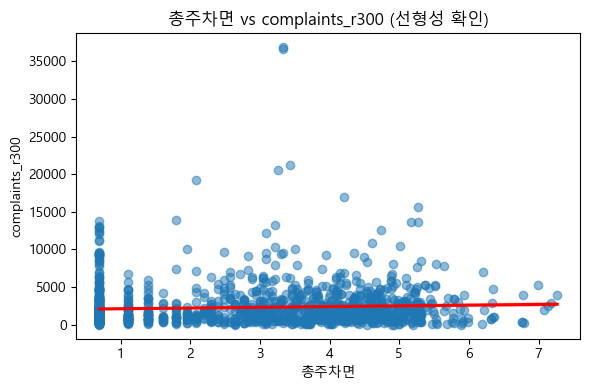

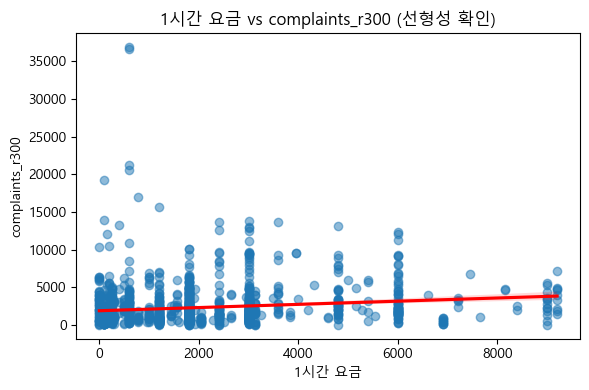

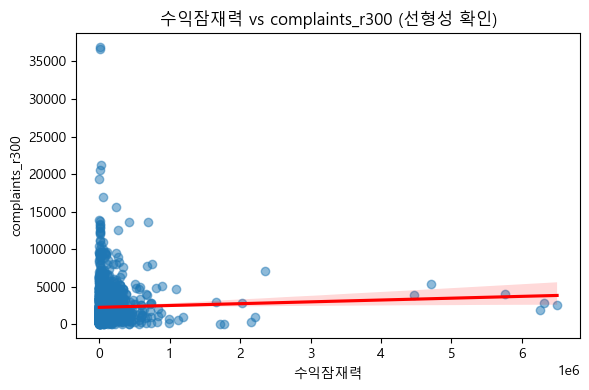

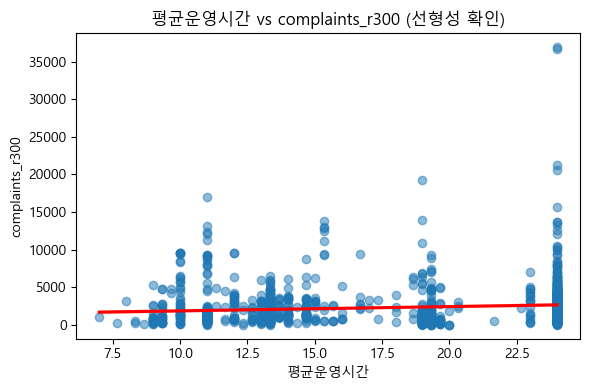

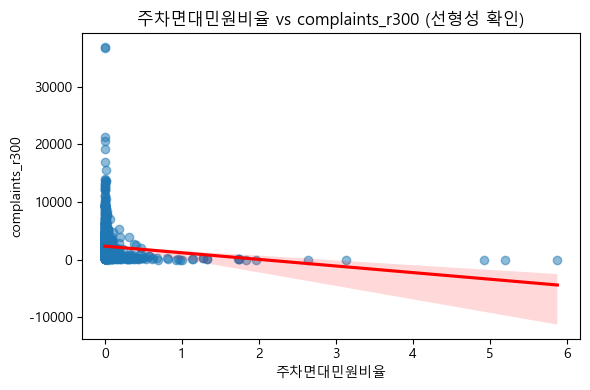

In [70]:
predictor.check_linearity(target_column='complaints_r300')

In [71]:
predictor.linearity_r2_scores(target_column='complaints_r300')


=== 단변량 선형 R² 값 ===
    feature     R2
1    1시간 요금  0.021
4  주차면대민원비율  0.017
3    평균운영시간  0.012
0      총주차면  0.004
2     수익잠재력  0.001


,feature,R2
1,1시간 요금,0.021480
4,주차면대민원비율,0.017202
3,평균운영시간,0.012105
0,총주차면,0.003684
2,수익잠재력,0.001391


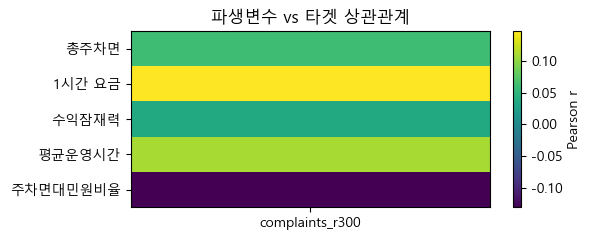


=== VIF (분산팽창요인) ===
    feature   VIF
0      총주차면  5.74
3    평균운영시간  5.56
1    1시간 요금  1.81
2     수익잠재력  1.35
4  주차면대민원비율  1.16


(총주차면        0.060694
 1시간 요금      0.146561
 수익잠재력       0.037301
 평균운영시간      0.110025
 주차면대민원비율   -0.131157
 Name: complaints_r300, dtype: float64,
     feature       VIF
 0      총주차면  5.737913
 3    평균운영시간  5.556682
 1    1시간 요금  1.812893
 2     수익잠재력  1.346329
 4  주차면대민원비율  1.155930)

In [72]:
predictor.feature_diagnostics(target_column='complaints_r300')

In [73]:
# 데이터 분할
predictor.split_data()


--- NaN 체크 (타겟: complaints_r300) ---
X 각 컬럼별 NaN 개수:
X 전체 NaN 개수: 0
y NaN 개수: 0
전체 데이터 수: 1405

--- 결측치 처리 ---
타깃 평균: 2279.17
타깃 분산: 7498189.41
분산/평균 비율: 3289.87

--- 데이터 정규화 ---
데이터 분할 완료:
Train: 983 (70.0%)
Val: 281 (20.0%)
Test: 141 (10.0%)

--- 타겟 변수 (complaints_r300) 분포 ---
Train - 평균: 2312.19, 표준편차: 2666.16
Val - 평균: 2038.49, 표준편차: 2301.60
Test - 평균: 2528.61, 표준편차: 3815.00


In [74]:
# # 모델 학습
predictor.train_model()


=== LINEAR 회귀 모델 학습 중... ===
검증 결과:
  MSE: 4988220.6029
  RMSE: 2233.4325
  MAE: 1353.7059
  R²: 0.0550


{'model_type': 'linear',
 'val_mse': 4988220.602947084,
 'val_rmse': 2233.432471096246,
 'val_mae': 1353.7059429201213,
 'val_r2': 0.05499204385570111}

In [75]:
# # 모델 평가
results = predictor.evaluate_model()


=== 모델 최종 평가 (테스트 데이터) ===
최종 테스트 결과:
  MSE: 12921000.1526
  RMSE: 3594.5793
  MAE: 1707.4748
  R²: 0.1059
  설명분산점수: 0.1083
  MAPE: 1344097657.43%

실제값 범위: 0.00 ~ 36939.00
예측값 범위: 26.53 ~ 5547.81



=== 회귀 계수 분석 ===
절편 (Intercept): 2312.1923

절댓값 기준 상위 15개 특성:
          feature  coefficient  abs_coefficient
7    운영구분_encoded    -506.7553         506.7553
15       주차면대민원비율    -446.3589         446.3589
2          평일운영시간     420.2701         420.2701
5       cctv_r300     381.0742         381.0742
1          1시간 요금     291.9704         291.9704
0            총주차면    -291.2169         291.2169
4         공휴일운영시간    -244.1770         244.1770
6   주차장종류_encoded     202.1643         202.1643
14          인프라밀도    -142.2371         142.2371
12         평균운영시간     124.3114         124.3114
9   토요일유료_encoded     103.4096         103.4096
3         토요일운영시간      79.7031          79.7031
10  공휴일유료_encoded     -60.3261          60.3261
11          수익잠재력     -30.8206          30.8206
8    평일유료_encoded      30.0766          30.0766

민원 증가에 가장 큰 영향 (상위 10개):
          feature  coefficient
2          평일운영시간     420.2701
5       cctv_r300     381.0742
1          1시간 요금     291.9704
6   주차장종류_encoded  

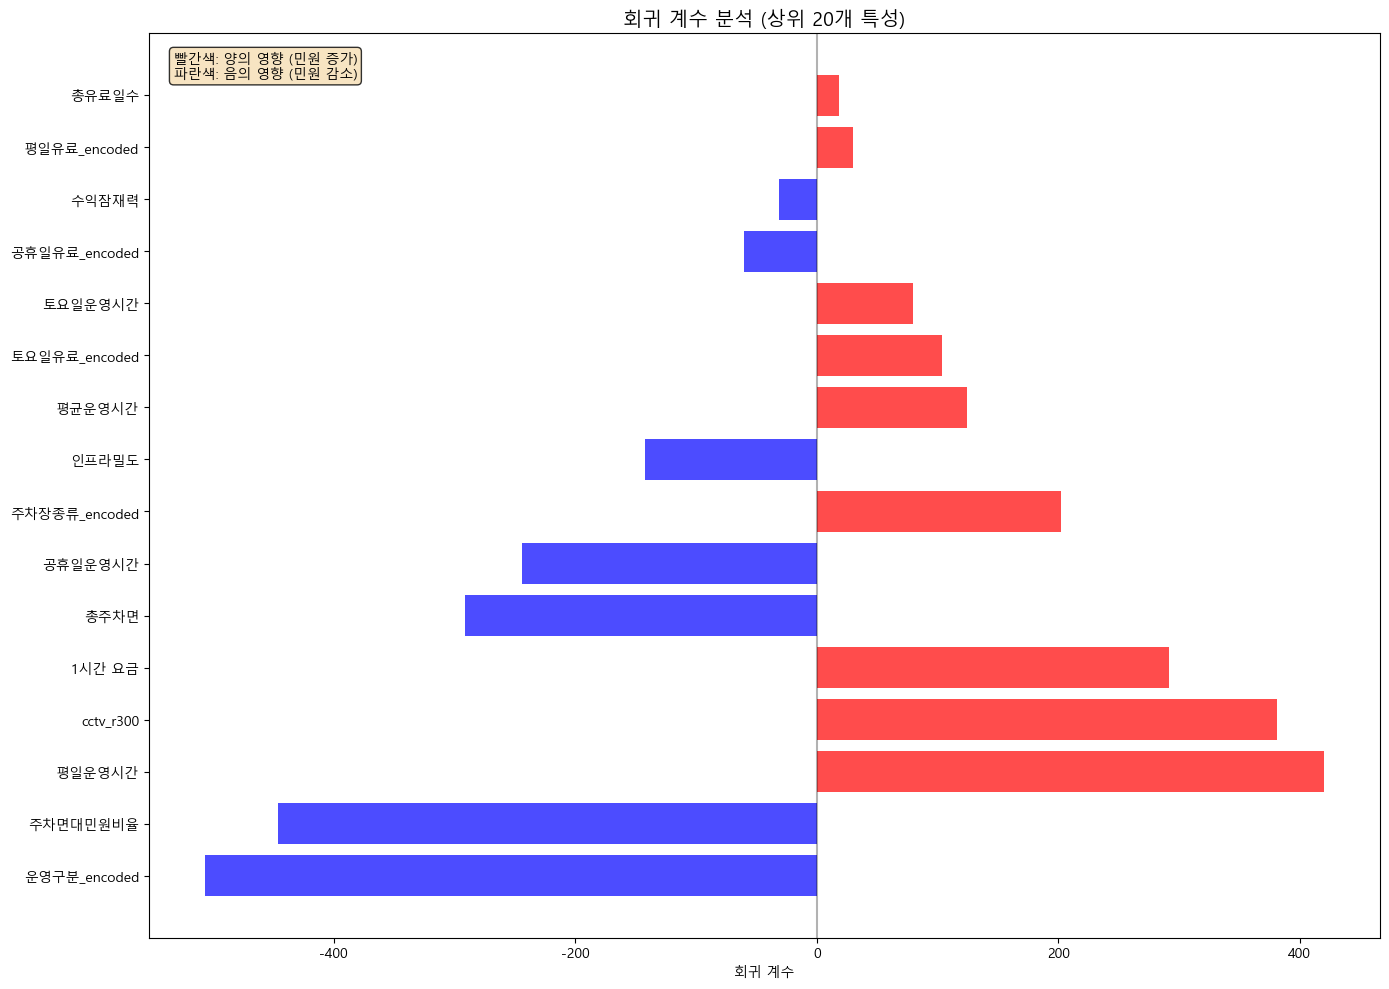

In [76]:
# 회귀 계수 분석
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

coefficients = predictor.analyze_coefficients()